# Diffraction Pattern Indexing with VAE

This notebook demonstrates how to use the `DiffractionPatternIndexer` to encode diffraction patterns into a latent space and retrieve their crystallographic orientations. The indexer uses a combination of:

1. A variational autoencoder (VAE) model to encode patterns into a latent representation
2. A vector database (ChromaDB) to efficiently store and retrieve latent vectors and their orientations

## Setup

First, let's load the necessary modules and configure auto-reloading for code changes.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

# Project imports
from src.index.dp_indexer import DiffractionPatternIndexer, IndexerConfig
from src.index.chroma_db import LatentVectorDatabaseConfig, LatentVectorDatabase
from src.model import VariationalAutoEncoderRawData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'ebsd_vae'

## Initialise the Indexer

Now let's set up the indexer with the VAE model and a ChromaDB vector database. The indexer will automatically:
1. Load the diffraction patterns and orientation data
2. Encode the patterns into the latent space
3. Build a searchable database of latent vectors and their orientations

In [2]:
# Initialise the VAE model
model = VariationalAutoEncoderRawData()

# Initialise the vector database
db = LatentVectorDatabase(
    config=LatentVectorDatabaseConfig(
        collection_name="tutorial",  # Name for this collection
        persist_directory=".chroma_db",  # Directory to save the database
        dimension=16  # Latent space dimension
    )
)

# Initialise the indexer
indexer = DiffractionPatternIndexer(
    model=model,
    db=db,
    config=IndexerConfig(
        pattern_path=Path("data/sample_pattern.npy"),
        angles_path=Path("data/anglefile_sample.txt"),
        batch_size=64,
        device="cpu",  # Change to "cuda" or "mps" if available
        latent_dim=16,
        random_seed=42,
        image_size=(128, 128),
        top_n=20,  # Number of nearest neighbors to consider
        orientation_threshold=3.0,  # Maximum misorientation angle (degrees)
    ),
)

2025-03-26 23:28:58,253 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-03-26 23:28:58,358 - src.index.chroma_db - INFO - Created persistent ChromaDB at .chroma_db
2025-03-26 23:28:58,367 - src.index.chroma_db - INFO - Created new collection 'tutorial'
2025-03-26 23:28:58,369 - src.index.dp_indexer - INFO - Using device: cpu
2025-03-26 23:28:58,376 - src.data_module - INFO - Loaded diffraction pattern data from data/sample_pattern.npy
2025-03-26 23:28:58,385 - src.data_module - INFO - Dataset initialized with 625 samples
2025-03-26 23:28:58,386 - src.data_module - INFO - Test dataset prepared with 625 samples
2025-03-26 23:28:58,386 - src.index.dp_indexer - INFO - Generating latent vectors from patterns in data/sample_pattern.npy
2025-03-26 23:28:58,387 - src.index.dp_indexer - INFO - Processing 10 batches...
2025-03-26 23:29:16,412 - src.index.dp_indexer - INFO - Adding 

Output()

2025-03-26 23:29:16,593 - src.index.chroma_db - INFO - Successfully added 625 vectors to the database


## Explore the Data

Let's take a look at the diffraction patterns and their orientations:

2025-03-26 23:29:44,815 - src.data_module - INFO - Loaded diffraction pattern data from data/sample_pattern.npy
2025-03-26 23:29:44,818 - src.data_module - INFO - Dataset initialized with 625 samples
2025-03-26 23:29:44,818 - src.data_module - INFO - Test dataset prepared with 625 samples


Patterns shape: torch.Size([64, 1, 128, 128])
Orientations shape: torch.Size([64, 3])


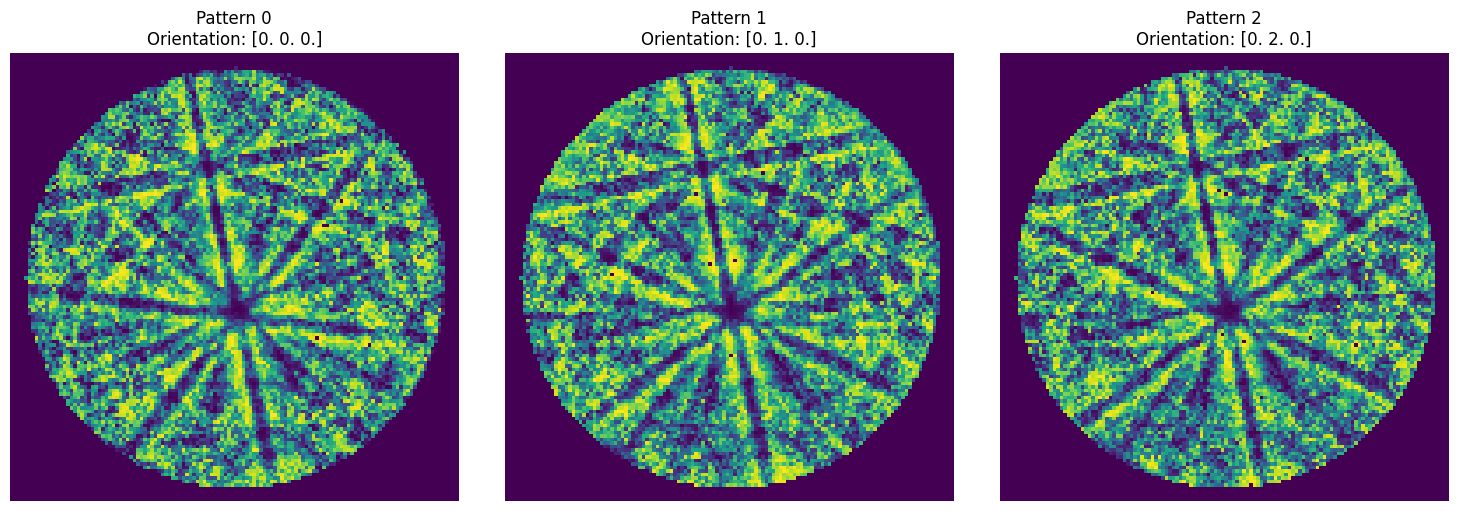

In [3]:
# Load a sample batch from the dataloader
dataloader = indexer._create_dataloader()
sample_batch = next(iter(dataloader))
patterns, orientations = sample_batch

# Display the shape of the data
print(f"Patterns shape: {patterns.shape}")
print(f"Orientations shape: {orientations.shape}")

# Visualize a few patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(patterns[i].squeeze(), cmap='viridis')
    axes[i].set_title(f"Pattern {i}\nOrientation: {orientations[i].numpy()}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Indexing Single Patterns

Now let's index a single diffraction pattern and examine the results:

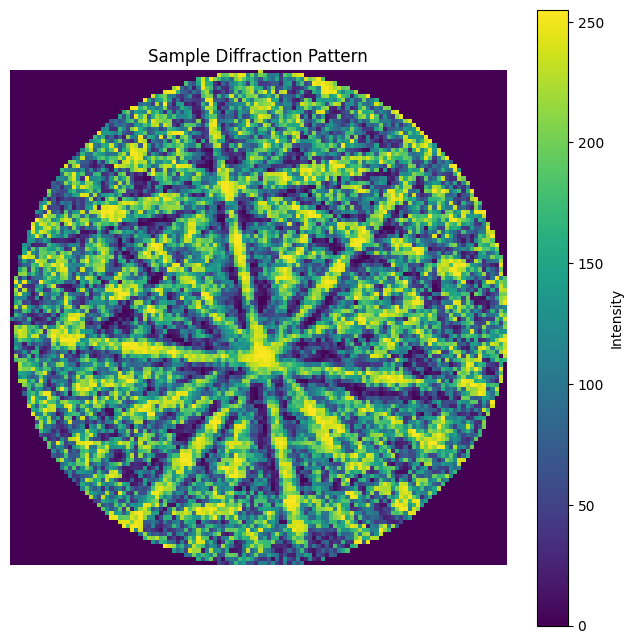

Indexed pattern in 0.1020 seconds
Best orientation: [-180.            4.63995708  180.        ]
Success: True


/Users/andrewtung/Documents/Github/ebsd-vae/src/index/dp_indexer.py:189: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  orientation = self.db.find_best_orientation(


In [4]:
# Load a sample pattern
sample_pattern = np.load("data/sample_pattern.npy")[0]

# Display the pattern
plt.figure(figsize=(8, 8))
plt.imshow(sample_pattern, cmap="viridis")
plt.title("Sample Diffraction Pattern")
plt.colorbar(label="Intensity")
plt.axis("off")
plt.show()

# Time the indexing operation
start_time = time.time()
orientation_result = indexer.index_pattern(
    pattern=sample_pattern, top_n=20, orientation_threshold=3.0
)
end_time = time.time()

print(f"Indexed pattern in {end_time - start_time:.4f} seconds")
print(f"Best orientation: {orientation_result.mean_orientation}")
print(f"Success: {orientation_result.success}")

## The Latent Space Representation

We can also examine the latent vector representation of a pattern:

Latent vector dimension: (16,)
Latent vector: [ 0.95896655  0.56664634 -1.6231264   1.550308   -0.30780095  1.6021867
  2.0120564  -0.8864872   0.7186871   2.240191   -2.0162964  -0.4132199
 -1.0085526   0.10438615 -0.8935094  -1.5007896 ]


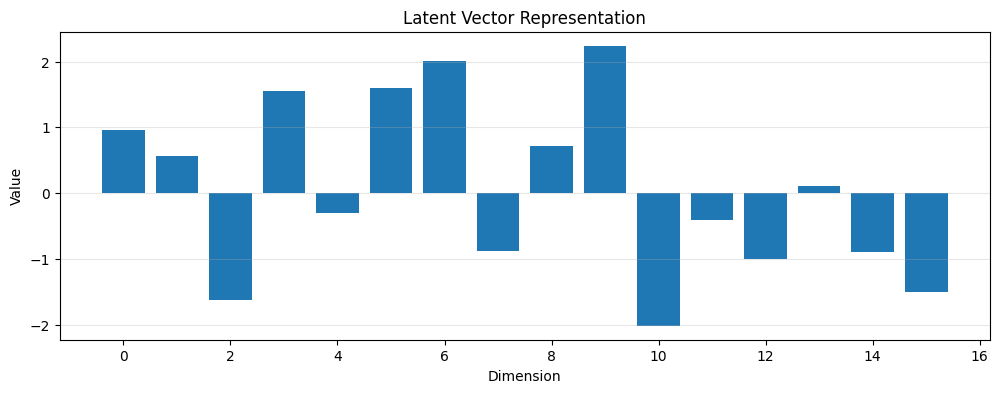

In [6]:
# Encode the pattern to get its latent representation
latent_vector = indexer.encode_pattern(sample_pattern)
print(f"Latent vector dimension: {latent_vector.shape}")
print(f"Latent vector: {latent_vector}")

# Visualize the latent vector
plt.figure(figsize=(12, 4))
plt.bar(range(len(latent_vector)), latent_vector)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Latent Vector Representation')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Batch Processing

For efficiency, the indexer also supports batch processing of multiple patterns:

Output()

2025-03-27 00:56:34,450 - src.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations
2025-03-27 00:56:34,456 - src.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations
2025-03-27 00:56:34,461 - src.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations
2025-03-27 00:56:34,466 - src.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations
2025-03-27 00:56:34,472 - src.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations


Indexed 5 patterns in 0.2401 seconds
Average time per pattern: 0.0480 seconds

Results summary:
Pattern 0: None (success: False)
Pattern 1: None (success: False)
Pattern 2: None (success: False)
Pattern 3: None (success: False)
Pattern 4: None (success: False)


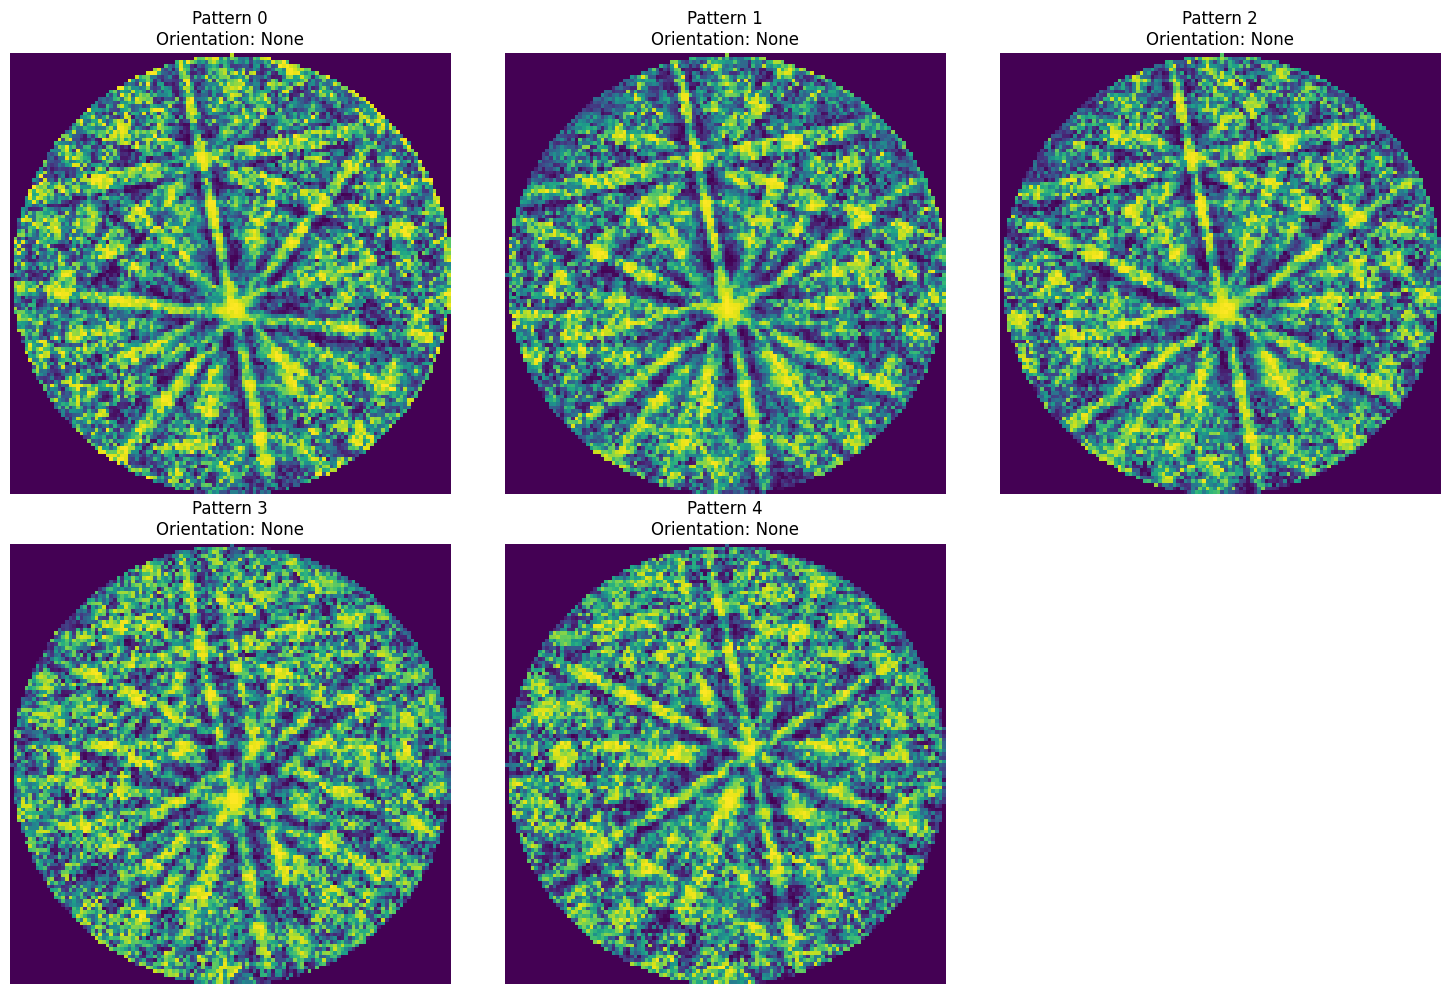

In [17]:
# Load multiple patterns
batch_patterns = np.load("data/sample_pattern.npy")[:5]

# Time batch indexing
start_time = time.time()
orientation_results = indexer.index_patterns_batch(batch_patterns)
end_time = time.time()

print(f"Indexed {len(batch_patterns)} patterns in {end_time - start_time:.4f} seconds")
print(f"Average time per pattern: {(end_time - start_time) / len(batch_patterns):.4f} seconds")

# Display results
print("\nResults summary:")
for i, result in enumerate(orientation_results):
    print(f"Pattern {i}: {result.mean_orientation} (success: {result.success})")

# Visualize the orientations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(5):
    # Plot the pattern
    axes[i].imshow(batch_patterns[i], cmap='viridis')
    axes[i].set_title(f"Pattern {i}\nOrientation: {orientation_results[i].mean_orientation}")
    axes[i].axis('off')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()